In [87]:
# Import packages
import numpy as np
import pandas as pd
import chardet
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
import string
import time



import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, make_scorer, confusion_matrix
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.preprocessing import LabelBinarizer
from sklearn.svm import SVC

from keras.models import Model
from keras.layers import Input, Dense, Flatten, Dropout, Embedding
from keras.layers.convolutional import Conv1D, MaxPooling1D
from tensorflow.keras.layers import concatenate
from keras.optimizers import Adam
from keras.preprocessing.text import one_hot
from keras.callbacks import ModelCheckpoint 
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from scipy import sparse, stats
import utils.text_processing as util



In [88]:
# Display plots inline
% matplotlib inline

UsageError: Line magic function `%` not found.


In [89]:
#Parameters
OUTPUT_CLASSES = 22
FILE_NAME = "../Data/processed_data.csv"
SEQUENCE_LENGTH = 35
EMBEDDING_SIZES =[300,250,150,50]
BATCH_SIZE = 32
EPOCH_LENGTH = 10
VALIDATION_PERCENTAGE = 0.1
TEST_SIZE_PERCENTAGE = 0.2
Y_LABEL_NAME="username"
NUMBER_K_FOLDS = 3


In [90]:
# Define model architecture in keras
# Code reference: https://machinelearningmastery.com/develop-n-gram-multichannel-convolutional-neural-network-sentiment-analysis/
def define_model(input_len, output_size, vocab_sizes, embedding_dims, verbose = True,
                drop_out_pct = 0.25, conv_filters = 500, activation_fn = 'tanh', pool_size = 2, learning = 0.0001):
    
    # Channel 1
    inputs1 = Input(shape = (input_len,))
    embedding1 = Embedding(vocab_sizes[0], embedding_dims[0])(inputs1)
    drop1 = Dropout(drop_out_pct)(embedding1)
    conv1 = Conv1D(filters = conv_filters, kernel_size = 3, activation = activation_fn)(drop1)
    pool1 = MaxPooling1D(pool_size = pool_size)(conv1)
    flat1 = Flatten()(pool1)
    
    # Channel 2
    inputs2 = Input(shape = (input_len,))
    embedding2 = Embedding(vocab_sizes[1], embedding_dims[1])(inputs2)
    drop2 = Dropout(drop_out_pct)(embedding2)
    conv2 = Conv1D(filters = conv_filters, kernel_size = 4, activation = activation_fn)(drop2)
    pool2 = MaxPooling1D(pool_size = pool_size)(conv2)
    flat2 = Flatten()(pool2)

    # Channel 3
    inputs3 = Input(shape = (input_len,))
    embedding3= Embedding(vocab_sizes[2], embedding_dims[2])(inputs3)
    drop3 = Dropout(drop_out_pct)(embedding3)
    conv3 = Conv1D(filters = conv_filters, kernel_size = 5, activation = activation_fn)(drop3)
    pool3 = MaxPooling1D(pool_size = pool_size)(conv3)
    flat3 = Flatten()(pool3)
    
    # Channel 4
    inputs4 = Input(shape = (input_len,))
    embedding4 = Embedding(vocab_sizes[3], embedding_dims[3])(inputs4)
    drop4 = Dropout(drop_out_pct)(embedding4)
    conv4 = Conv1D(filters = conv_filters, kernel_size = 6, activation = activation_fn)(drop4)
    pool4 = MaxPooling1D(pool_size = pool_size)(conv4)
    flat4 = Flatten()(pool4)
    
    # Merge channels
    merged = concatenate([flat1, flat2, flat3, flat4])
    
    # Create output layer
    output = Dense(output_size, activation = 'softmax')(merged)
    
    # Create model
    model = Model(inputs = [inputs1, inputs2, inputs3, inputs4], outputs = output)
    
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer = Adam(learning_rate = learning), metrics=['accuracy'])
    
    if verbose:
        print(model.summary())

    return model
        

In [91]:
data = pd.read_csv(FILE_NAME)

In [92]:
#Get text and y label
text = data['raw_text']
author = data['username']

In [93]:
text_train, text_test, author_train, author_test = train_test_split(text, author, test_size = TEST_SIZE_PERCENTAGE, random_state = 5)

In [94]:
# Check shapes of created datasets
print(np.shape(text_train))
print(np.shape(text_test))
print(np.shape(author_train))
print(np.shape(author_test))

(21933,)
(5484,)
(21933,)
(5484,)


In [95]:
# Determine vocab sizes for n-grams
vocab_sizes = []
for i in range(1, 4):
    vocab_size = util.get_vocab_size(text_train, i, SEQUENCE_LENGTH)
    vocab_sizes.append(vocab_size)
    print('Vocab size for n =', i, 'is:', vocab_size)

Vocab size for n = 1 is: 62
Vocab size for n = 2 is: 3178
Vocab size for n = 3 is: 31569


In [96]:
gram1_train = util.create_n_grams(text_train, 1, vocab_sizes[0], SEQUENCE_LENGTH)
gram2_train = util.create_n_grams(text_train, 2, vocab_sizes[1], SEQUENCE_LENGTH)
gram3_train = util.create_n_grams(text_train, 3, vocab_sizes[2], SEQUENCE_LENGTH)

gram1_test = util.create_n_grams(text_test, 1, vocab_sizes[0], SEQUENCE_LENGTH)
gram2_test = util.create_n_grams(text_test, 2, vocab_sizes[1], SEQUENCE_LENGTH)
gram3_test = util.create_n_grams(text_test, 3, vocab_sizes[2], SEQUENCE_LENGTH)

print(np.shape(gram1_train))
print(np.shape(gram2_train))
print(np.shape(gram3_train))

print(np.shape(gram1_test))
print(np.shape(gram2_test))
print(np.shape(gram3_test))

(21933, 35)
(21933, 35)
(21933, 35)
(5484, 35)
(5484, 35)
(5484, 35)


In [97]:
# Determine maximum value of n-gram encodings (this is used to set the CNN embedding dimension)
max_1gram = np.max(gram1_train)
max_2gram = np.max(gram2_train)
max_3gram = np.max(gram3_train)

print('Maximum encoding value for 1-grams is: ', max_1gram)
print('Maximum encoding value for 2-grams is: ', max_2gram)
print('Maximum encoding value for 3-grams is: ', max_3gram)

Maximum encoding value for 1-grams is:  79
Maximum encoding value for 2-grams is:  4130
Maximum encoding value for 3-grams is:  41039


In [98]:
# One hot encode labels
author_lb = LabelBinarizer()
author_lb.fit(author_train)
author_train_hot = author_lb.transform(author_train)
author_test_hot = author_lb.transform(author_test)

In [99]:
gram3_train.shape

(21933, 35)

In [100]:
# Model 1 Sensitivity Testing

kf = KFold(n_splits = NUMBER_K_FOLDS)

test_accuracy_list = []
prec_list = []
recall_list = []
f1_list = []
training_time_list = []
prediction_time_list = []
full_history =[]

run = 0


for train_inds, _ in kf.split(gram3_train):
    run += 1
    print('Run:', run)
       
    train_x = np.array([gram3_train[i] for i in train_inds])
    train_y = np.array([author_train_hot[i] for i in train_inds])
    
    t0 = time.time()
    # Fit model
    model = define_model(SEQUENCE_LENGTH, OUTPUT_CLASSES, [max_3gram + 1,max_3gram + 1,max_3gram + 1,max_3gram + 1], [EMBEDDING_SIZES[0],EMBEDDING_SIZES[1],EMBEDDING_SIZES[2],EMBEDDING_SIZES[3]],verbose = False)
    histroy = model.fit([train_x, train_x, train_x, train_x], train_y, epochs=EPOCH_LENGTH, batch_size=BATCH_SIZE, 
                verbose = 1, validation_split = VALIDATION_PERCENTAGE)
    
    t1 = time.time()
    # Predict values for test set
    author_pred1 = model.predict([gram3_test, gram3_test, gram3_test,gram3_test])
    author_pred1 = author_lb.inverse_transform(author_pred1)

    t2 = time.time()
    # Evaluate
    test_accuracy = accuracy_score(author_test, author_pred1)
    precision, recall, f1, support = score(author_test, author_pred1)
    ave_precision = np.average(precision, weights = support/np.sum(support))
    ave_recall = np.average(recall, weights = support/np.sum(support))
    ave_f1 = np.average(f1, weights = support/np.sum(support))
    training_time = (t1 - t0)
    prediction_time = (t2 - t1)
    
    test_accuracy_list.append(test_accuracy)
    prec_list.append(ave_precision)
    recall_list.append(ave_recall)
    f1_list.append(ave_f1)
    training_time_list.append(training_time)
    prediction_time_list.append(prediction_time)
    full_history.append(histroy)

print("Accuracy:", test_accuracy_list)
print("Ave. Precision:", prec_list)
print("Ave. Recall:", recall_list)
print("Ave. F1 Score:", f1_list)

Run: 1
Epoch 1/10
412/412 [==============================] - 91s 218ms/step - loss: 2.6202 - accuracy: 0.2164 - val_loss: 2.4310 - val_accuracy: 0.3459
Epoch 2/10
412/412 [==============================] - 90s 219ms/step - loss: 2.1638 - accuracy: 0.4262 - val_loss: 1.9025 - val_accuracy: 0.4942
Epoch 3/10
412/412 [==============================] - 90s 218ms/step - loss: 1.5852 - accuracy: 0.5753 - val_loss: 1.5374 - val_accuracy: 0.5701
Epoch 4/10
412/412 [==============================] - 90s 218ms/step - loss: 1.1961 - accuracy: 0.6793 - val_loss: 1.3748 - val_accuracy: 0.6015
Epoch 5/10
412/412 [==============================] - 89s 217ms/step - loss: 0.9154 - accuracy: 0.7655 - val_loss: 1.3130 - val_accuracy: 0.6138
Epoch 6/10
412/412 [==============================] - 89s 217ms/step - loss: 0.6890 - accuracy: 0.8346 - val_loss: 1.3350 - val_accuracy: 0.6145
Epoch 7/10
412/412 [==============================] - 89s 217ms/step - loss: 0.5076 - accuracy: 0.8881 - val_loss: 1.3094 -

c:\Python39\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/10
412/412 [==============================] - 91s 218ms/step - loss: 2.6305 - accuracy: 0.2044 - val_loss: 2.4361 - val_accuracy: 0.3404
Epoch 2/10
412/412 [==============================] - 89s 217ms/step - loss: 2.1771 - accuracy: 0.4182 - val_loss: 1.8972 - val_accuracy: 0.5099
Epoch 3/10
412/412 [==============================] - 89s 216ms/step - loss: 1.5925 - accuracy: 0.5767 - val_loss: 1.5335 - val_accuracy: 0.5646
Epoch 4/10
412/412 [==============================] - 89s 217ms/step - loss: 1.2082 - accuracy: 0.6726 - val_loss: 1.3851 - val_accuracy: 0.5954
Epoch 5/10
412/412 [==============================] - 90s 219ms/step - loss: 0.9238 - accuracy: 0.7610 - val_loss: 1.3321 - val_accuracy: 0.6111
Epoch 6/10
412/412 [==============================] - 92s 224ms/step - loss: 0.6957 - accuracy: 0.8299 - val_loss: 1.3114 - val_accuracy: 0.6268
Epoch 7/10
412/412 [==============================] - 92s 222ms/step - loss: 0.5111 - accuracy: 0.8861 - val_loss: 1.3724 - val_ac

c:\Python39\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/10
412/412 [==============================] - 120s 289ms/step - loss: 2.6326 - accuracy: 0.2057 - val_loss: 2.4435 - val_accuracy: 0.3083
Epoch 2/10
412/412 [==============================] - 118s 287ms/step - loss: 2.1848 - accuracy: 0.4084 - val_loss: 1.9315 - val_accuracy: 0.4716
Epoch 3/10
412/412 [==============================] - 118s 286ms/step - loss: 1.6154 - accuracy: 0.5676 - val_loss: 1.6020 - val_accuracy: 0.5509
Epoch 4/10
412/412 [==============================] - 117s 284ms/step - loss: 1.2245 - accuracy: 0.6712 - val_loss: 1.4505 - val_accuracy: 0.5830
Epoch 5/10
412/412 [==============================] - 110s 267ms/step - loss: 0.9381 - accuracy: 0.7581 - val_loss: 1.4001 - val_accuracy: 0.5926
Epoch 6/10
412/412 [==============================] - 116s 282ms/step - loss: 0.7073 - accuracy: 0.8316 - val_loss: 1.3984 - val_accuracy: 0.6036
Epoch 7/10
412/412 [==============================] - 117s 285ms/step - loss: 0.5226 - accuracy: 0.8856 - val_loss: 1.4274 -

c:\Python39\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [101]:
#Get averages for kfold runs
mean_accuracy_across_kfold = np.mean(test_accuracy_list)
mean_percision_across_kfold = np.mean(prec_list)
mean_recall_across_kfold = np.mean(recall_list)
mean_f1_across_kfold = np.mean(f1_list)


print("Average Accuracy across K-folds:", mean_accuracy_across_kfold)
print("Average Precision across K-folds:", mean_percision_across_kfold)
print("Average Recall across K-folds:", mean_recall_across_kfold)
print("Average F1 Score across K-folds:", mean_f1_across_kfold)
print("Average Training Time across K-folds:", (t1 - t0), "seconds")
print("Prediction Time across K-folds:", (t2 - t1), "seconds")

Average Accuracy across K-folds: 0.6150012156576707
Average Precision across K-folds: 0.6274886681337266
Average Recall across K-folds: 0.6150012156576709
Average F1 Score across K-folds: 0.6184632175867214
Average Training Time across K-folds: 1157.7209587097168 seconds
Prediction Time across K-folds: 3.2377235889434814 seconds


In [102]:
average_test_loss_accross_kfold = []
average_validation_loss_accross_kfold = []
average_test_accuracy_accross_kfold = []
average_validation_accuracy_accross_kfold = []

for i in range(len(full_history)):
    average_test_loss_accross_kfold.append(full_history[i].history['loss'])
    average_validation_loss_accross_kfold.append(full_history[i].history['val_loss'])

    average_test_accuracy_accross_kfold.append(full_history[i].history['accuracy'])
    average_validation_accuracy_accross_kfold.append(full_history[i].history['val_accuracy'])

average_loss_accross_kfold = np.mean(average_test_loss_accross_kfold,axis=0)
average_validation_loss_accross_kfold = np.mean(average_validation_loss_accross_kfold,axis=0)

average_accuracy_accross_kfold = np.mean(average_test_accuracy_accross_kfold,axis=0)
average_validation_accuracy_accross_kfold = np.mean(average_validation_accuracy_accross_kfold,axis=0)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


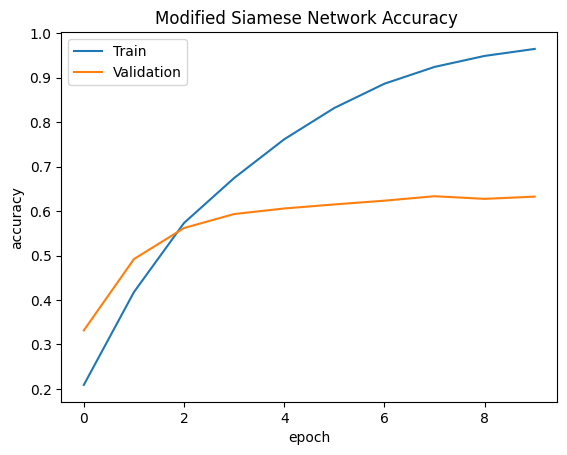

In [103]:
# summarize history for accuracy
plt.plot(average_accuracy_accross_kfold)
plt.plot(average_validation_accuracy_accross_kfold)
plt.title('Modified Siamese Network Accuracy ')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig("outputs/modified_siamases_network_acc.eps", format='eps')
plt.show()


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


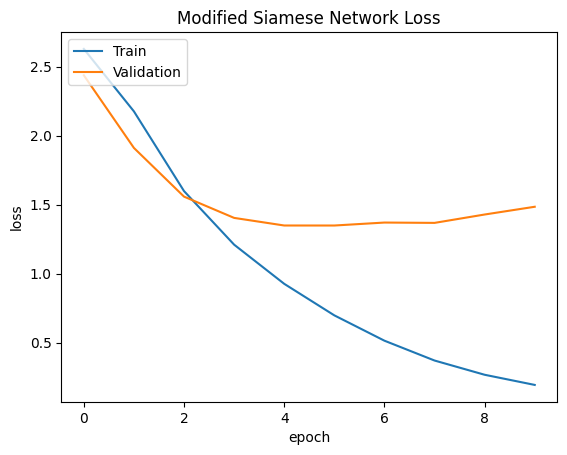

In [104]:
# summarize history for loss
plt.plot(average_loss_accross_kfold)
plt.plot(average_validation_loss_accross_kfold)
plt.title('Modified Siamese Network Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig("outputs/modified_siamese_network_loss.eps", format='eps')
plt.show()